In [1]:
from tree_detection_framework.preprocessing.preprocessing import create_dataloader, visualize_dataloader
from tree_detection_framework.detection.detector import DeepForestDetector

from tree_detection_framework.postprocessing.postprocessing import multi_region_NMS

/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
dataloader = create_dataloader(
        raster_folder_path='/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho',
        chip_size=100,
        chip_stride=50,
        use_units_meters=True,
        output_resolution=0.2,
    )

In [3]:
len(dataloader)

36

/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


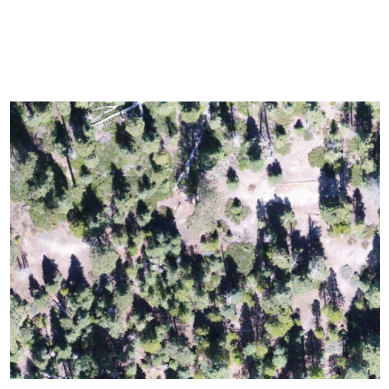

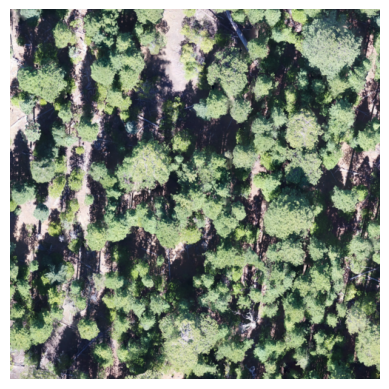

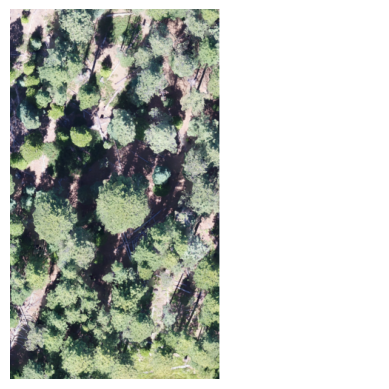

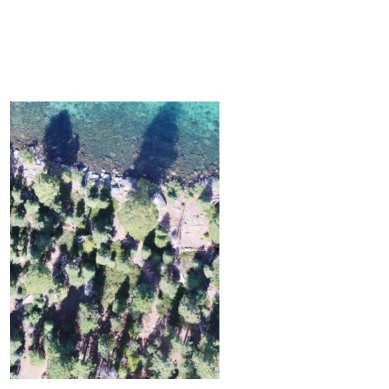

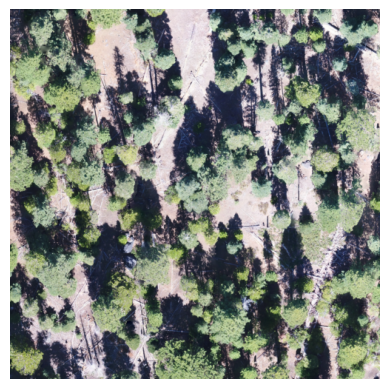

In [4]:
visualize_dataloader(dataloader, 5)

In [5]:
model = DeepForestDetector()

Reading config file: /ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/deepforest/main.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.loa

Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [6]:
predictions = model.predict(dataloader)

/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/deepforest/main.py:338: UserWarning: Image type is uint8, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn(f"Image type is {image.dtype}, transforming to float32. "
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/si

In [7]:
predictions[0]

,xmin,ymin,xmax,ymax,label,score
0,164.0,422.0,188.0,449.0,Tree,0.642623
1,364.0,142.0,401.0,181.0,Tree,0.618745
2,251.0,206.0,288.0,242.0,Tree,0.604112
3,225.0,70.0,260.0,106.0,Tree,0.599384
4,422.0,80.0,463.0,120.0,Tree,0.588728
...,...,...,...,...,...,...
60,242.0,271.0,274.0,305.0,Tree,0.198579
61,404.0,181.0,439.0,217.0,Tree,0.197015
62,230.0,2.0,265.0,34.0,Tree,0.191969
63,107.0,318.0,144.0,354.0,Tree,0.191410


In [8]:
import shapely
import pandas as pd
from tree_detection_framework.detection.region_detections import RegionDetections, RegionDetectionsSet

def get_pixel_bounds_box_from_sample(sample):
    # Get the shape of the image
    image_shape = sample["image"].shape[-2:]
    # Create a box from it, noting that the shape is i, j
    image_bounds = shapely.box(xmin=0, ymin=0, xmax=image_shape[1], ymax=image_shape[0])
    # Duplicate by the number of elements in the box
    image_bounds_batch = [image_bounds] * sample["image"].shape[0]
    return image_bounds_batch

def get_geospatial_bounds_box_from_sample(sample):
    # Extract the bounds field
    batch_bounds = sample["bounds"]
    # The bounds are different for each region in the batch, so create a box for each one
    geospatial_bounds_batch = [
        shapely.box(
            xmin=tile_bounds.minx,
            ymin=tile_bounds.miny,
            xmax=tile_bounds.maxx,
            ymax=tile_bounds.maxy
        )
        for tile_bounds in batch_bounds
    ]

    return geospatial_bounds_batch

def parse_deepforest_output(prediction: pd.DataFrame):
    # Create a list of shapely objects from the deepforest predictions
    xmin = prediction["xmin"].to_numpy()
    ymin = prediction["ymin"].to_numpy()
    xmax = prediction["xmax"].to_numpy()
    ymax = prediction["ymax"].to_numpy()
    prediction_geometry = shapely.box(xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)
    return prediction_geometry

# Create a list of RegionDetection objects
region_detections = []
for sample, prediction in zip(dataloader, predictions):
    # Extract the derived attributes from the sample and prediction
    # Note that the first element is taken from the ones where a batch is returned
    image_bounds = get_pixel_bounds_box_from_sample(sample)[0]
    geospatial_bounds = get_geospatial_bounds_box_from_sample(sample)[0]
    prediction_geometry = parse_deepforest_output(prediction)

    # Extract the CRS of the first (only) element in the batch
    CRS = sample["crs"][0]

    # Create the region detection
    region_detection = RegionDetections(
        detection_geometries=prediction_geometry,
        data=prediction,
        pixel_prediction_bounds=image_bounds,
        geospatial_prediction_bounds=geospatial_bounds,
        input_in_pixels=True,
        CRS=CRS,
    )
    # Append to the list
    region_detections.append(region_detection)

# Create the region detection set and save
region_detection_set = RegionDetectionsSet(region_detections)
region_detection_set.save("/ofo-share/repos-david/tree-detection-framework/data/predictions.geojson")

/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
/ofo-share/repos-david/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. 

In [10]:
NMS_suppressed_detections = multi_region_NMS(region_detection_set)
NMS_suppressed_detections.save("/ofo-share/repos-david/tree-detection-framework/data/predictions_NMS.geojson")